In [2]:
import sys
sys.path.insert(0, '../')
import numpy as np
import matplotlib.pyplot as plt
from src.ModelClasses import Geometry, CellType, Water, Solute, Grid, BoundSolute
from src.ModelSetup import Nondimensionalise, CalculateTimestep
from src.TimestepManager import Timestep
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

In [3]:
timestep_sizes = [1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4, 1e-3]

cell_outputs = []
cell_cons_errors = []

for timestep in timestep_sizes:

    # --------------------------------------  MODEL SETUP

    # Input model geometry and (dimensional) parameters

    geometry = Geometry(T = 1e5, L = 3e-3)

    cell = CellType(diffusion_rate = 1e-14, initial_volume_fraction = 0.05, chemotaxis_strength=1.36, chemotaxis_strength_bound=42.4, matrix_drag=9.89e9, matrix_traction=0.0, contact_inhibition=0.0, aggregation_strength=0)

    water = Water(matrix_volume_fraction=0.03, matrix_drag=5e7)

    solute = Solute(diffusion_rate = 1e-11, initial_solute_concentration = 0.0, production_rate=8.74e-11, uptake_rate=0, degradation_rate=8.21e-4, binding_rate=1.5e-3)

    bound_solute = BoundSolute(initial_solute_concentration=0, unbinding_rate=3.7e-3, degradation_rate=8.21e-4)

    # Initialise grid
    nx = 3000

    grid = Grid(nx = nx, dx = 1/nx)

    # Set initial cell and water distributions

    multiplier = int(nx/100)
    np.random.seed(28) #fix noise distribution to be the same every time
    cell.distribution = cell.initial_volume_fraction + np.random.normal(0, 0.1*cell.initial_volume_fraction, 100)
    cell.distribution = np.repeat(cell.distribution, multiplier)
    water.distribution = water.available_volume_fraction - cell.distribution

    # Set initial cell velocity

    cell.velocity = np.zeros(grid.nx)

    # Set initial solute distribution

    solute.distribution = solute.uniform_solute_distribution(water, grid)

    bound_solute.distribution = bound_solute.uniform_solute_distribution(water, grid)

    # Save initial distributions

    initial_cell_distribution = cell.distribution
    initial_solute_distribution = solute.distribution

    # Nondimensionalise the input parameters

    Nondimensionalise(cell, solute, bound_solute, water, geometry, cM = 1e-9, cell_viscosity = 1e4)

    # Set timestep and find number of timesteps

    dt = timestep
    Tmax = 0.2
    nsteps = int(Tmax/dt)
    print(nsteps)

    # -------------------------------- RUN THE MODEL

    cons_init = np.sum(cell.distribution)

    for t in tqdm(range(nsteps+1)):
        Timestep(cell, solute, bound_solute, water, grid, dt)

    # Calculate conservation error

    cons_final = np.sum(cell.distribution)

    print('cons_error =', (cons_final - cons_init)/cons_init)
    cell_cons_errors.append(np.abs(cons_final - cons_init)/cons_init)

    # Save average cell volume fraction in list

    cell_outputs.append(np.sum(cell.distribution)/(nx))


  0%|          | 7/2001 [00:00<00:31, 63.59it/s]

2000


  1%|          | 6/1001 [00:00<00:16, 59.11it/s]

cons_error = 2.3728015819332936e-06
1000


  1%|          | 6/667 [00:00<00:11, 58.50it/s]

cons_error = 3.6382717713175537e-06
666


  1%|▏         | 7/501 [00:00<00:07, 64.06it/s]

cons_error = 4.287503927787124e-06
500


  2%|▏         | 7/401 [00:00<00:05, 67.92it/s]

cons_error = 4.848782342639569e-06
400


  1%|▏         | 5/334 [00:00<00:07, 45.06it/s]

cons_error = 5.411717151727566e-06
333


  2%|▏         | 5/286 [00:00<00:06, 46.41it/s]

cons_error = 6.0071268564560566e-06
285


  3%|▎         | 8/251 [00:00<00:03, 75.62it/s]

cons_error = 6.643553324526926e-06
250


  2%|▏         | 5/223 [00:00<00:04, 49.28it/s]

cons_error = 7.345844724302411e-06
222


  3%|▎         | 7/201 [00:00<00:03, 63.39it/s]

cons_error = 8.051756227627819e-06
200


100%|██████████| 201/201 [00:02<00:00, 69.12it/s]

cons_error = 8.78557767932875e-06


In [4]:
cells_time_error = []

for i in range(1, len(cell_outputs)):
    cells_time_error.append(np.abs(cell_outputs[i] - cell_outputs[0])/cell_outputs[i])

In [6]:
timesteps = timestep_sizes[1:]

# make list of timesteps for x axis
mx = len(timesteps) - 1

x = np.linspace(np.log(timesteps[0]), np.log(timesteps[mx]), 100)

# find line of gradient 1 through one of data points
Ynint = np.log(np.abs(cells_time_error[0])) - 1 * np.log(timesteps[0])
Yn = Ynint + (1 * x)

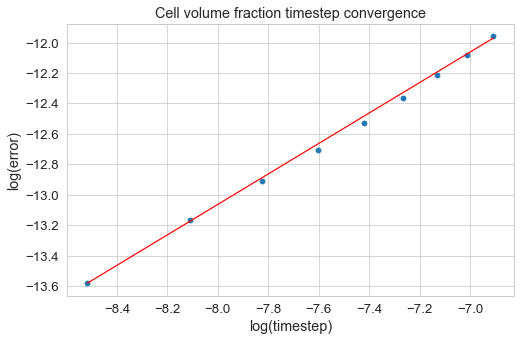

In [7]:
# plot cell volume fraction error against timestep only

plt.figure(figsize=(8, 5))
plt.plot(np.log(timesteps), np.log(np.abs(cells_time_error)), 'o')
plt.title('Cell volume fraction timestep convergence')
plt.xlabel('log(timestep)')
plt.ylabel('log(error)')
plt.plot(x, Yn, 'r')
#plt.savefig('cell_timestep_convergence.png')

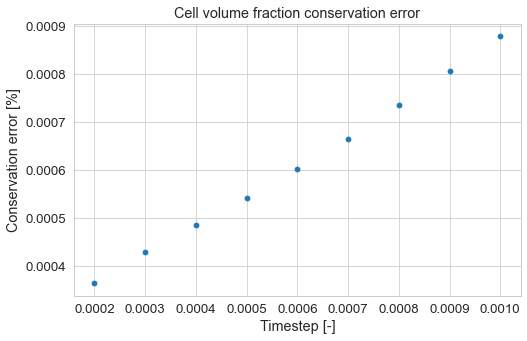

In [8]:
# plot cell_cons_errors

plt.figure(figsize=(8, 5))
plt.plot(timestep_sizes[1:], 100*np.abs(cell_cons_errors[1:]), 'o')
plt.title('Cell volume fraction conservation error')
plt.xlabel('Timestep [-]')
plt.ylabel('Conservation error [%]')
#plt.savefig('cell_timestep_conservation_error.png')